In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import time
from skimage import io
from skimage import transform, filters, color
from scipy import ndimage

In [3]:
def isMagicCard(approx):
    """
    Decides whether an approximate contour is a MTG Card.
    
    This is done by checking whether the area of the contour is withing a
    range that fits for a magic card and checking if the contour is a
    rectangle.
    
    Returns:
    -True, if the contour is a MTG Card
    -False, otherwise
    """
    MIN_AREA = 5000
    MAX_AREA = 15000
    
    area = cv2.contourArea(approx)
    
    if(area > MIN_AREA and area < MAX_AREA and len(approx) == 4):
        return True
    else:
        return False

In [4]:
def removeDoubleDetects(rectangles):
    """
    Removes all rectangles that are too simillar to be different cards.
    
    Compares the center positions of all the rectangles and removes
    the ones with distances are below a threshold.
    
    """
    
    # The threshold that is the minimum distance between two rectangles
    DISTANCE_THRESHOLD = 50
    
    # The center positions of all the rectangles that have not been removed.
    centers = []
    
    # The array of rectangles that will be returned
    returnRectangles = []
    
    for rectangle in rectangles:
        # Get the center of the rectangle
        x, y, width, height = cv2.boundingRect(rectangle)
        center = np.array([x - width, y - height])
        
        # Indicates whether there is a rectangle that is too simillar.
        double = False
        
        # Check for all known centers, if the new one is too simillar.
        for cent in centers:
            dist = np.linalg.norm(center - cent)
            
            if(dist < DISTANCE_THRESHOLD):
                double = True
        
        # If the rectangle is not a double detection add its center to the array of
        # known centers and the rectangle to the array of rectangles that will be returned
        if(not double):
            centers.append(center)
            returnRectangles.append(rectangle)
            
    return returnRectangles

In [5]:
CARD_ORIENTATION_UP = 0
CARD_ORIENTATION_RIGHT = 1
CARD_ORIENTATION_DOWN = 2
CARD_ORIENTATION_LEFT = 3

def getCardOrientation(x, y, width, height):
    
    tapped = None
    
    if(width > height):
        tapped = False
    else:
        tapped = True
    
    if(not tapped):
        if(x < 423):
            return CARD_ORIENTATION_RIGHT
        else:
            return CARD_ORIENTATION_LEFT
    else:
        if(x < 423):
            return CARD_ORIENTATION_DOWN
        else:
            return CARD_ORIENTATION_UP
    

In [6]:
def sortRectangle(rectangle):
    rectangle = rectangle.flatten()

    r = []

    for i in range(0, 7, 2):

        r.append([rectangle[i], rectangle[i + 1]])


    rectangle = sorted(r, key=lambda x: x[1])
    left = [rectangle[0], rectangle[1]]
    right = [rectangle[2], rectangle[3]]

    left = sorted(left, key=lambda x:x[0])
    right = sorted(right, key=lambda x:x[0])
    
    rectangle = []
    rectangle.append(left[0])
    rectangle.append(left[1])
    rectangle.append(right[0])
    rectangle.append(right[1])

    return rectangle

In [7]:
def applyPerspectiveTransform(cardImage, rectangle):
    
    x, y, width, height = cv2.boundingRect(rectangle)
    
    
    
    rectangle[:,0][:,0] = rectangle[:,0][:,0] - x
    
    rectangle[:,0][:,1] = rectangle[:,0][:,1] - y
    
   

    rectangle = sortRectangle(rectangle)
    
    print rectangle
    
    pts1 = np.float32(rectangle)
    
        
    #pts1 = np.float32([[10, 10], [110, 10], [10, 80], [110, 80]])
    pts2 = np.float32([[0, 0],[120, 0],[0, 85],[120,85]])

    transformationMatrix = cv2.getPerspectiveTransform(pts1,pts2)

    return cv2.warpPerspective(cardImage, transformationMatrix,(85, 120))

In [8]:
def preprocessImage(image):
    """
    Preprocesses the given image, so it can be used to find cards in it.
    
    Returns the preprocessed image.
    """

    # Only view the part of, the image where the actual game is taking place.
    imageOut = image[0:845, 168:1200]
    
    imageOut = cv2.cvtColor(imageOut, cv2.COLOR_BGR2GRAY)
    
    # Apply a simple threshold to the image.
    # All dark spots become white, so the black card borders are clear
    imageOut = cv2.inRange(imageOut, 0, 75)
    
    
    return imageOut

In [9]:
def findCards(image):
    """
    Finds all the cards in the given image.
    The image has to be already preprocessed, so it will be easy to find
    contours.
    
    Returns an array of rectangles that indicate where the cards are.
    """
    
    # Find contours in the image
    contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    rects = []

    
    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.1 * cv2.arcLength(cnt, True), True)
       
        # Check if the contour is a magic card
        if(isMagicCard(approx)):
            rects.append(approx)
    
    # Remove all the cards that were detected twice.
    rects = removeDoubleDetects(rects)
    
    return rects

In [10]:
def getCardImages(image, rectangles):
    
    cardImages = []
    
    for rectangle in rectangles:
        x, y, width, height = cv2.boundingRect(rectangle)
        

        
        cardImage = image[y:y + height, x:x + width]
        
        #cardOrientation = getCardOrientation(x, y, width, height)
        cardOrientation = getRotation(image, x, y, width, height)
        
        rotationFactor = 0
        
        if(cardOrientation == CARD_ORIENTATION_UP):
            rotationFactor = 0
        elif(cardOrientation == CARD_ORIENTATION_RIGHT):
            rotationFactor = 90
        elif(cardOrientation == CARD_ORIENTATION_DOWN):
            rotationFactor = 180
        elif(cardOrientation == CARD_ORIENTATION_LEFT):
            rotationFactor = -90
            
        cardImage = ndimage.rotate(cardImage, rotationFactor)
        
        # TODO apply perspective transform
        
        #cardImage = applyPerspectiveTransform(cardImage, rectangle)
        cardImage = cv2.resize(cardImage, (85, 120), interpolation = cv2.INTER_CUBIC)
        
        cardImages.append(cardImage)
    
    return cardImages

In [11]:
import featureM as fm

Populating the interactive namespace from numpy and matplotlib
Started computing keypoints for  orb
Finished computing keypoints for orb


In [12]:
def getRotation(img, x, y, width, height):
    # Indicates whether the card is tapped or not
    tapped = None
    
    
    
    if(width > height):
        tapped = False
    else:
        tapped = True
    
    # If the card is not tapped the orientation is determined by which side of the image the card is on.
    if(not tapped):
        if(x < 423):
            return CARD_ORIENTATION_RIGHT
        else:
            return CARD_ORIENTATION_LEFT
    else:
        # Get the card image from the image
        cardImage = img[y:y + height, x:x + width]

        # Set a lower and upper bound 
        lower = np.array([0, 0, 0])
        upper = np.array([90, 90, 90])

        cardImage = cv2.inRange(cardImage, lower, upper)

        topHalf = cardImage[0:height / 2, 0:width]
        bottomHalf = cardImage[height / 2:height, 0:width]

        topCount = np.sum(topHalf)
        bottomCount = np.sum(bottomHalf)

        if(topCount > bottomCount):
            return CARD_ORIENTATION_UP
        else:
            return CARD_ORIENTATION_DOWN
            

In [13]:

def showHoverdCard(event, x, y, flags, param):
    
    # Check for the user moving the mouse
    if(event == cv2.EVENT_MOUSEMOVE):
        for rectangle in cardRectangles:
            boxX, boxY, boxWidth, boxHeight = cv2.boundingRect(rectangle)
            
            if(x > boxX and x < boxX + boxWidth and y > boxY and y < boxY + boxHeight):

                    cardImg = getCardImages(frame, [rectangle])
                    cardImg = cardImg[0][0:70, 0:85]
                    bestMatch, confidence = fm.findBestMatchOrb(cardImg)
                    print bestMatch
                    bestMatchImg = cv2.imread(os.getcwd() + bestMatch)

                    cv2.imshow("cardDisplay", bestMatchImg)
                    cv2.imshow("extractedCard", cardImg)
            


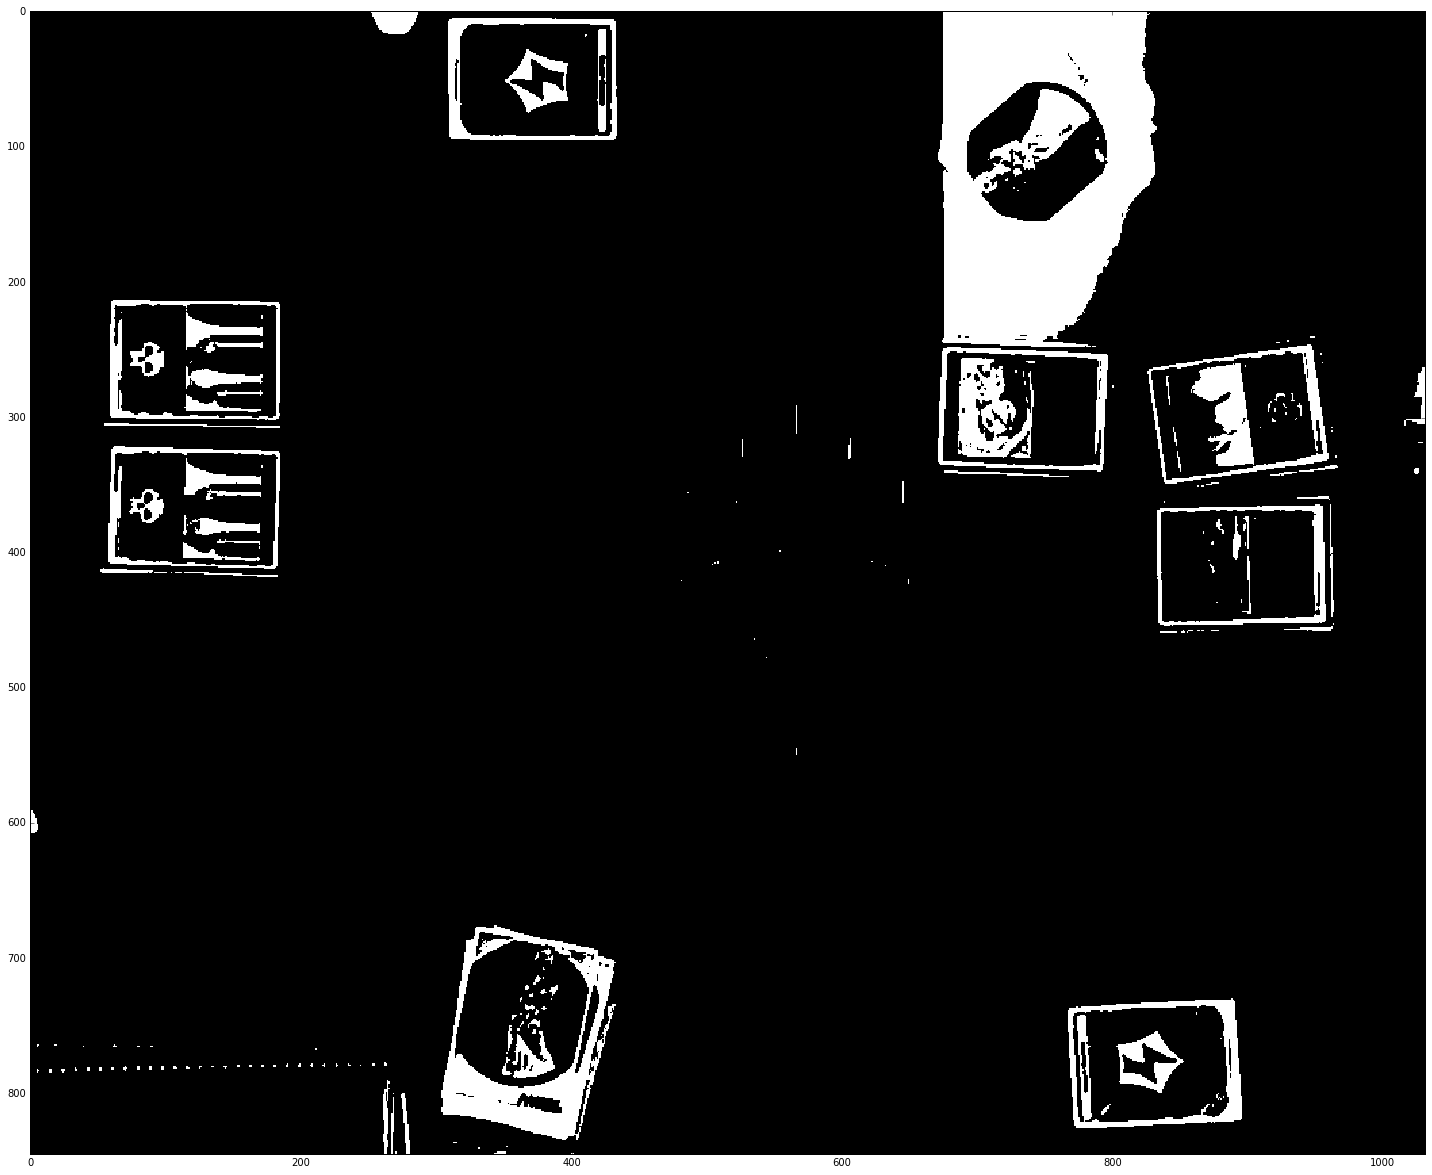

In [14]:
# Create an image of the preprocessing step
img = cv2.imread(os.getcwd() + "/screenshot9.png")

imgPre = preprocessImage(img)
plt.fig = plt.figure(figsize= (20,20))
io.imshow(imgPre)
io.imsave(os.getcwd() + '/final.png', imgPre)

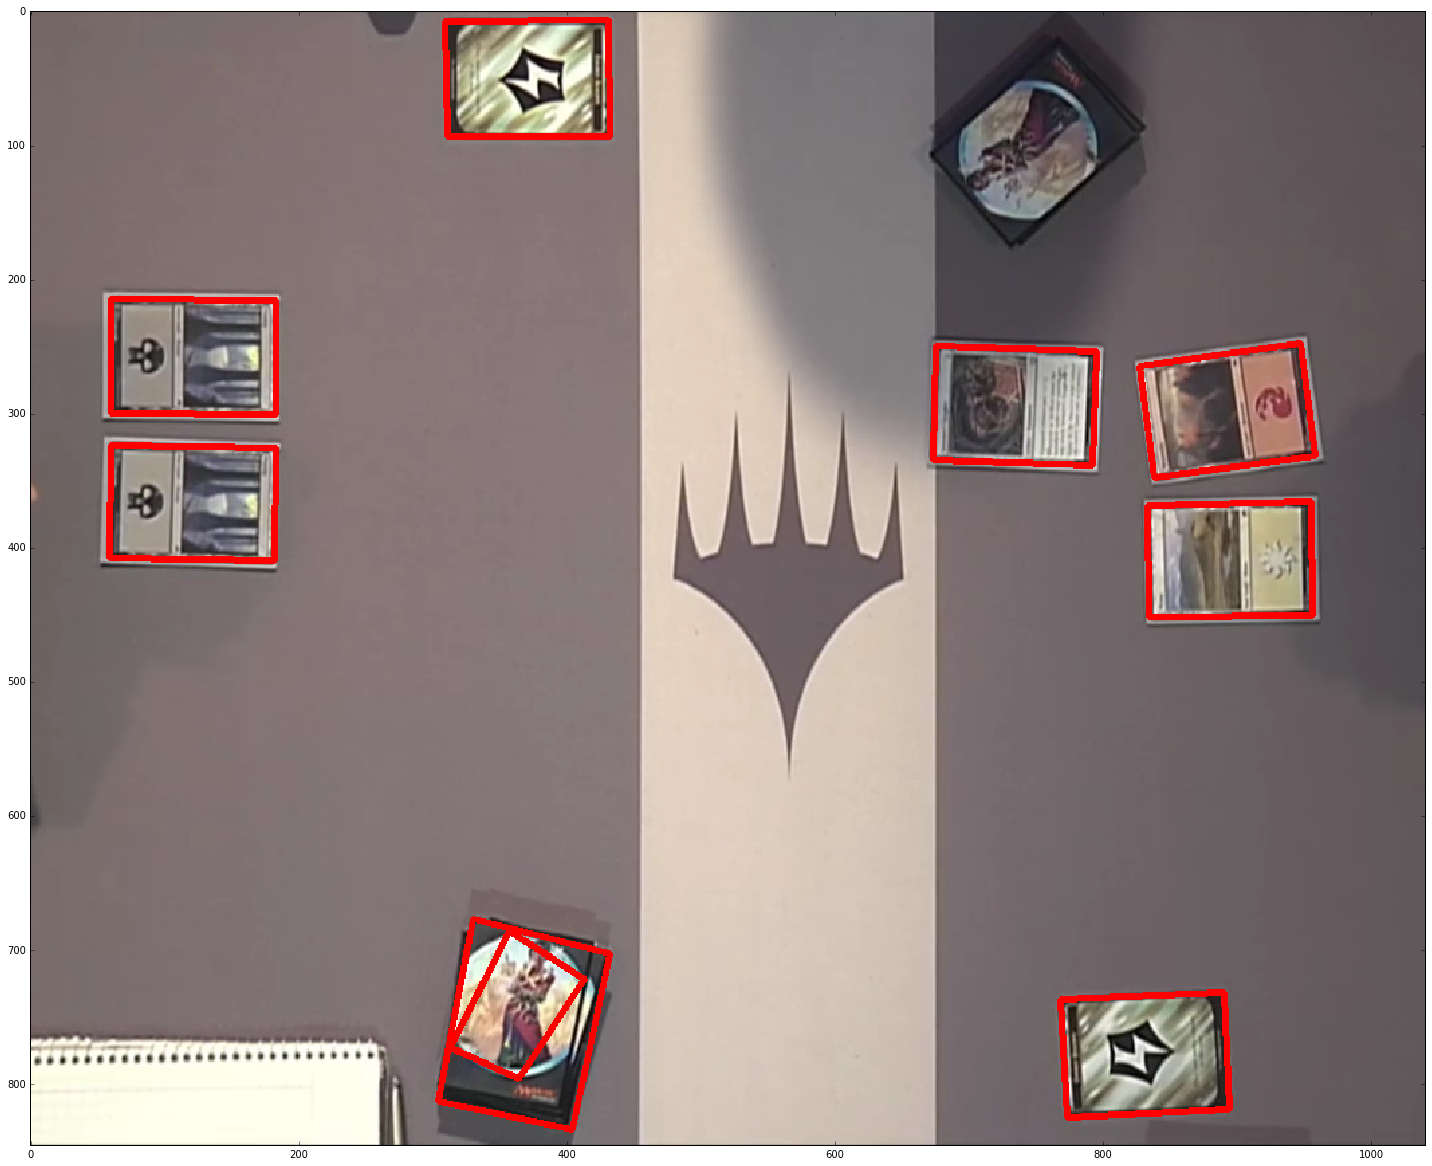

In [15]:
# Create an image of the final localisation

cardRectangles = findCards(imgPre)


frame = img[0:846, 168:1209]
cv2.drawContours(frame, cardRectangles, -1, (0, 0, 255), 3)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.fig = plt.figure(figsize= (20,20))
io.imshow(frame)
io.imsave(os.getcwd() + '/final.png', frame)

In [18]:
# Cycle through all test videos and extract found cards
for q in range(1, 2):
    
    #video = cv2.VideoCapture(os.getcwd() + "/data/video/draft" + str(q) + ".mp4")#
    video = cv2.VideoCapture(os.getcwd() + "/data/video/output1.mp4")

    cv2.namedWindow("frame")
    cv2.setMouseCallback("frame", showHoverdCard)

    cardDict = {}
    # Blacklist cards that we recently found as they are unlikely to already have moved/rotated
    blackList = {}

    n = 0
    m = 0
    while(True):
        # Capture frame-by-frame
        frame = video.grab()
        #if(n % 5 == 0):

        ret, frame = video.retrieve()
        
        if frame is None:
            break
            
        imgPre = preprocessImage(frame)


        cardRectangles = findCards(imgPre)

        frame = frame[0:846, 168:1209]
        cv2.drawContours(frame, cardRectangles, -1, (355, 0, 0), 3)

        # Display the resulting frame
        cv2.imshow('frame',frame)

        
        n = n + 1
        #if((n % (60 * 3)) == 0):
        if(False):
            imgPre = preprocessImage(frame)


            cardRectangles = findCards(imgPre)

            frame = frame[0:846, 168:1209]
            cv2.drawContours(frame, cardRectangles, -1, (355, 0, 0), 3)

            # Display the resulting frame
            cv2.imshow('frame',frame)

            m = m + 1
            cardImages = getCardImages(frame, cardRectangles)
            c = 0

            for cardImg in cardImages:
                bestMatch, confidence = fm.findBestMatchOrb(cardImg)

                if confidence > 0.8:
                    directory = os.getcwd() + "/data/generated/" + os.path.basename(bestMatch).split('.')[0]

                    if not os.path.exists(directory):
                        os.makedirs(directory)

                    cardCount = len(os.listdir(directory))


                    if blackList.has_key(bestMatch):
                        if blackList[bestMatch] < m:
                            uid = time.time()

                            cv2.imwrite(directory + '/' + str(uid) + ".png", cardImg) 
                            blackList[bestMatch] = m + cardCount
                    else:
                        uid = time.time()
                        cv2.imwrite(directory + '/' + str(uid) + ".png", cardImg) 
                        blackList[bestMatch] = m + cardCount

                c = c + 1
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        elif cv2.waitKey(1) & 0xFF == ord('s'):
            cardImages = getCardImages(frame, cardRectangles)
            c = 0
            for cardImg in cardImages:
                cv2.imwrite(os.getcwd() + "/data/test/img" + str(c) + ".png", cardImg)
                c = c + 1

    video.release()
    cv2.destroyAllWindows()

Softmax 0.999999988795
/data/img/KLD/Energy Token.png
Softmax 0.999999988795
/data/img/KLD/Energy Token.png
Softmax 0.999999197606
/data/img/KLD/Ninth Bridge Patrol.png
Softmax 0.999999197606
/data/img/KLD/Ninth Bridge Patrol.png
Softmax 0.999999197606
/data/img/KLD/Ninth Bridge Patrol.png
Softmax 0.999999197606
/data/img/KLD/Ninth Bridge Patrol.png
Softmax 0.998724618941
/data/img/KLD/Energy Token.png
Softmax 0.998724618941
/data/img/KLD/Energy Token.png
Softmax 0.998724618941
/data/img/KLD/Energy Token.png
Softmax 0.998724618941
/data/img/KLD/Energy Token.png
Softmax 0.998724618941
/data/img/KLD/Energy Token.png
Softmax 0.999999993066
/data/img/KLD/Ruinous Gremlin.png
Softmax 0.999999993066
/data/img/KLD/Ruinous Gremlin.png
Softmax 0.999999993066
/data/img/KLD/Ruinous Gremlin.png
Softmax 0.999999993066
/data/img/KLD/Ruinous Gremlin.png
Softmax 0.0505052414634
/data/img/KLD/Foundry Inspector.png
Softmax 0.0505052414634
/data/img/KLD/Foundry Inspector.png
Softmax 0.0505052414634
/data/